<a href="https://colab.research.google.com/github/jacoguzo/Poker_Player_Markowitz/blob/main/2024_10_28_poker_player_modern_portfolio_(CU_server).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Poker Data Analysis and Player Portfolio Optimization

In this notebook, we will analyze poker hand history data to extract player statistics and construct an optimal portfolio of the top 20 players using Markowitz's portfolio theory.

Objectives:

Parse poker hand history files to extract relevant data.
Calculate key player statistics such as VPIP (Voluntarily Put Money in Pot), PFR (Pre-Flop Raise), Aggression Factor, net winnings, and variance.
Identify the top 20 players based on net winnings per hand.
Compute the covariance matrix of the net winnings among these top players.
Adjust the covariance matrix to ensure it is positive semi-definite.
Use portfolio optimization techniques to determine the optimal weights for each player in a portfolio, maximizing expected returns while controlling for risk.

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

For debugging purposes, set a variable in files, which is the number of files to be downloaded

In [ ]:
n_files=324


Importing Libraries

In [ ]:
# Import necessary libraries
import os
import re
from collections import defaultdict
import numpy as np
import pandas as pd
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from itertools import combinations  # Import combinations to use in covariance calculations





In [ ]:
file_links = [
    f"https://www.columbia.edu/~chw2/Courses/APMA4903/2024/logo/{i}.txt"
    for i in range(1, 325)
]

# Print to verify
for link in file_links:
    print(link)


https://www.columbia.edu/~chw2/Courses/APMA4903/2024/logo/1.txt
https://www.columbia.edu/~chw2/Courses/APMA4903/2024/logo/2.txt
https://www.columbia.edu/~chw2/Courses/APMA4903/2024/logo/3.txt
https://www.columbia.edu/~chw2/Courses/APMA4903/2024/logo/4.txt
https://www.columbia.edu/~chw2/Courses/APMA4903/2024/logo/5.txt
https://www.columbia.edu/~chw2/Courses/APMA4903/2024/logo/6.txt
https://www.columbia.edu/~chw2/Courses/APMA4903/2024/logo/7.txt
https://www.columbia.edu/~chw2/Courses/APMA4903/2024/logo/8.txt
https://www.columbia.edu/~chw2/Courses/APMA4903/2024/logo/9.txt
https://www.columbia.edu/~chw2/Courses/APMA4903/2024/logo/10.txt
https://www.columbia.edu/~chw2/Courses/APMA4903/2024/logo/11.txt
https://www.columbia.edu/~chw2/Courses/APMA4903/2024/logo/12.txt
https://www.columbia.edu/~chw2/Courses/APMA4903/2024/logo/13.txt
https://www.columbia.edu/~chw2/Courses/APMA4903/2024/logo/14.txt
https://www.columbia.edu/~chw2/Courses/APMA4903/2024/logo/15.txt
https://www.columbia.edu/~chw2/Cou

Parsing Poker Hand History Files

We define a function parse_hand_history to parse the hand history files and extract relevant information such as player actions, net winnings, and board cards.

In [ ]:
def parse_hand_history(file_content):
    """
    Parses the content of a poker hand history file and extracts relevant data.

    Args:
        file_content (str): The content of the hand history file as a string.

    Returns:
        list: A list of dictionaries, each containing data for a single hand.
    """
    hands = file_content.strip().split('***** End of hand')
    hands_data = []
    for hand in hands:
        if '***** History for hand' not in hand:
            continue
        lines = hand.strip().split('\n')
        players = {}
        street = ''
        board_cards = []

        # Regular expression patterns
        seat_pattern = re.compile(r'Seat (\d+): (\S+) \(\$?([\d\.]+)\)')
        posting_blind_pattern = re.compile(r'(\S+) posts (small|big) blind \(\$([\d\.]+)\)')
        action_pattern = re.compile(r'(\S+) (bets|calls|raises|checks|folds|posts)(?: \$?([\d\.]+))?')
        win_pattern = re.compile(r'Seat \d+: (\S+) \(\$(\d{1,3}(?:,\d{3})*(?:\.\d{1,2})?)\), net: ([\+\-]\$\d{1,3}(?:,\d{3})*(?:\.\d{1,2})?)')

        for line in lines:
            line = line.strip()
            if line.startswith('Seat') and street != "summary1":
                m = seat_pattern.match(line)
                if m:
                    seat_no, player_name, stack = m.groups()
                    players[player_name] = {
                        'seat': seat_no,
                        'stack': float(stack),
                        'actions': [],
                        'net': 0.0
                    }
            elif 'posts' in line and ('small blind' in line or 'big blind' in line):
                m = posting_blind_pattern.match(line)
                if m:
                    player_name, blind_type, amount = m.groups()
                    amount = float(amount)
                    if player_name not in players:
                        players[player_name] = {
                            'seat': None,
                            'stack': None,
                            'actions': [],
                            'net': 0.0
                        }
                    players[player_name]['actions'].append({
                        'street': 'preflop',
                        'action': 'post ' + blind_type + ' blind',
                        'amount': amount
                    })
            elif line.startswith('Dealing pocket cards'):
                street = 'preflop'
            elif line.startswith('--- Dealing flop'):
                street = 'flop'
                board_cards.extend(re.findall(r'\[(.*?)\]', line))
            elif line.startswith('--- Dealing turn'):
                street = 'turn'
                board_cards.extend(re.findall(r'\[(.*?)\]', line))
            elif line.startswith('--- Dealing river'):
                street = 'river'
                board_cards.extend(re.findall(r'\[(.*?)\]', line))
            elif line.startswith('Summary:'):
                street = 'summary'
            elif street == 'summary':
                street ='summary1'
            elif street == 'summary1':
                m_win = win_pattern.match(line)
                if m_win:
                    player_name, stack_str, net_amount_str = m_win.groups()
                    stack = float(stack_str.replace(',', ''))
                    net_amount = float(net_amount_str.replace('$', '').replace(',', ''))
                    if player_name in players:
                        players[player_name]['net'] = net_amount
                        players[player_name]['stack'] = stack
            else:
                m = action_pattern.match(line)
                if m:
                    player_name, action, amount = m.groups()
                    amount = float(amount) if amount else 0.0
                    if player_name not in players:
                        players[player_name] = {
                            'seat': None,
                            'stack': None,
                            'actions': [],
                            'net': 0.0
                        }
                    players[player_name]['actions'].append({
                        'street': street,
                        'action': action,
                        'amount': amount
                    })
        hands_data.append({
            'players': players,
            'board': board_cards
        })
    return hands_data


In [ ]:
def calculate_metrics(hands_data):
    """
    Calculates player statistics from parsed hand data.

    Args:
        hands_data (list): A list of hand data dictionaries.

    Returns:
        dict: A dictionary containing player statistics.
    """
    player_stats = defaultdict(lambda: {
        'hands_played': 0,
        'vpip_count': 0,
        'pfr_count': 0,
        'postflop_aggr_actions': 0,
        'postflop_total_actions': 0,
        'net_blinds': 0.0,
        'net_blinds_per_hand': []
    })

    for hand in hands_data:
        big_blind = 1  # Default big blind value; will be updated if found in hand actions
        for player in hand['players'].values():
            for act in player['actions']:
                if act['action'] == 'post big blind':
                    big_blind = act['amount']
                    break

        # Calculate metrics for each player in the hand
        for player_name, data in hand['players'].items():
            player_stats[player_name]['hands_played'] += 1
            vpip = False
            pfr = False
            preflop_actions = [a for a in data['actions'] if a['street'] == 'preflop']
            postflop_actions = [a for a in data['actions'] if a['street'] in ('flop', 'turn', 'river')]

            # Count VPIP and PFR
            for action in preflop_actions:
                if action['action'] in ('calls', 'bets', 'raises'):
                    vpip = True
                if action['action'] == 'raises':
                    pfr = True

            # Count postflop aggression actions
            for action in postflop_actions:
                if action['action'] in ('bets', 'raises'):
                    player_stats[player_name]['postflop_aggr_actions'] += 1
                if action['action'] in ('bets', 'raises', 'calls', 'checks', 'folds'):
                    player_stats[player_name]['postflop_total_actions'] += 1

            if vpip:
                player_stats[player_name]['vpip_count'] += 1
            if pfr:
                player_stats[player_name]['pfr_count'] += 1

            # Calculate net winnings in terms of big blinds
            net_blinds_this_hand = data['net'] / big_blind
            player_stats[player_name]['net_blinds'] += net_blinds_this_hand
            player_stats[player_name]['net_blinds_per_hand'].append(net_blinds_this_hand)

    # Finalize statistics calculation
    for player_name, stats in player_stats.items():
        hands = stats['hands_played']
        stats['VPIP'] = (stats['vpip_count'] / hands) * 100 if hands > 0 else 0
        stats['PFR'] = (stats['pfr_count'] / hands) * 100 if hands > 0 else 0
        total_actions = stats['postflop_total_actions']
        stats['Agg'] = (stats['postflop_aggr_actions'] / total_actions) * 100 if total_actions > 0 else 'N/A'

        # Calculate variance of net blinds per hand
        if hands > 1:
            stats['net_blinds_variance'] = np.var(stats['net_blinds_per_hand'])
        else:
            stats['net_blinds_variance'] = 0

    return player_stats


In [ ]:
import os
import pandas as pd
import gdown

import os
import requests

import os
import requests

def download_files_from_columbia_server(file_links, output_directory, n):
    """
    Downloads the first 'n' files from the Columbia server and saves them to an output directory.

    Args:
        file_links (list): List of file links to download from the Columbia server.
        output_directory (str): The path to save the downloaded files.
        n (int): The number of files to download.

    Returns:
        list: List of downloaded file paths.
    """
    if not os.path.exists(output_directory):
        os.makedirs(output_directory)

    downloaded_files = []
    for i, file_link in enumerate(file_links[:n]):  # Limit to the first 'n' files
        try:
            # Extract file name from the URL
            file_name = file_link.split("/")[-1]
            output_path = os.path.join(output_directory, file_name)

            # Download the file from the Columbia server
            response = requests.get(file_link, stream=True)
            if response.status_code == 200:
                with open(output_path, 'wb') as f:
                    for chunk in response.iter_content(chunk_size=1024):
                        if chunk:
                            f.write(chunk)
                downloaded_files.append(output_path)
                print(f"Downloaded: {file_name}")
            else:
                print(f"Failed to download file from link: {file_link}. Status code: {response.status_code}")
        except Exception as e:
            print(f"Error downloading file from link: {file_link}. Error: {e}")

    return downloaded_files


def download_files_from_google_drive(file_links, output_directory):
    """
    Downloads files from Google Drive using gdown and saves them to an output directory.

    Args:
        file_links (list): List of file links to download.
        output_directory (str): The path to save the downloaded files.

    Returns:
        list: List of downloaded file paths.
    """
    if not os.path.exists(output_directory):
        os.makedirs(output_directory)

    downloaded_files = []
    for file_link in file_links:
        try:
            file_id = file_link.split('/d/')[-1].split('/')[0]
            if not file_id:
                print(f"Invalid file link: {file_link}")
                continue
            output_path = os.path.join(output_directory, f"{file_id}.txt")
            #gdown.download(f"https://drive.google.com/uc?id={file_id}", output_path, quiet=False)
            if os.path.exists(output_path):
                downloaded_files.append(output_path)
            else:
                print(f"Failed to download file from link: {file_link}")
        except Exception as e:
            print(f"Error downloading file from link: {file_link}. Error: {e}")

    return downloaded_files

def main(file_links, n_files):
    """
    Processes hand history files downloaded from Google Drive and computes player statistics.

    Args:
        file_links (list): List of Google Drive file links.

    Returns:
        pandas.DataFrame: A DataFrame containing player statistics.
    """
    # Download files to a temporary directory
#    downloaded_files = download_files_from_google_drive(file_links, 'downloaded_files')
    downloaded_files = download_files_from_columbia_server(file_links, 'downloaded_files', n_files  )


    # Process each downloaded file
    all_hands_data = []
    for filepath in downloaded_files:
        with open(filepath, 'r', encoding='utf-8') as file:
            file_content = file.read()
            hands_data = parse_hand_history(file_content)  # Assuming you have this function defined
            all_hands_data.extend(hands_data)

    # Calculate player statistics
    player_stats = calculate_metrics(all_hands_data)  # Assuming you have this function defined

    # Prepare data for DataFrame
    data = []
    for player, stats in player_stats.items():
        if stats['hands_played'] > 0:
            net_winnings_per_hand = stats['net_blinds'] / stats['hands_played']
            data.append({
                'Player': player,
                'Games Played': stats['hands_played'],
                'VPIP (%)': stats['VPIP'],
                'PFR (%)': stats['PFR'],
                'Agg (%)': stats['Agg'] if stats['Agg'] != 'N/A' else None,
                'Net Winnings per Hand (Big Blinds)': net_winnings_per_hand,
                'Net Winnings Variance': stats['net_blinds_variance']
            })

    # Create DataFrame
    df = pd.DataFrame(data)
    df['Net Winnings Variance per Game'] = df['Net Winnings Variance'] / df['Games Played']
    df = df[df['Net Winnings per Hand (Big Blinds)'] > 0]  # Filter out players with non-positive net winnings per hand

    return df



# Run the main function
df = main(file_links, n_files)
print(df)  # Display the resulting DataFrame


Downloaded: 1.txt
Downloaded: 2.txt
Downloaded: 3.txt
Downloaded: 4.txt
Downloaded: 5.txt
Downloaded: 6.txt
Downloaded: 7.txt
Downloaded: 8.txt
Downloaded: 9.txt
Downloaded: 10.txt
Downloaded: 11.txt
Downloaded: 12.txt
Downloaded: 13.txt
Downloaded: 14.txt
Downloaded: 15.txt
Downloaded: 16.txt
Downloaded: 17.txt
Downloaded: 18.txt
Downloaded: 19.txt
Downloaded: 20.txt
Downloaded: 21.txt
Downloaded: 22.txt
Downloaded: 23.txt
Downloaded: 24.txt
Downloaded: 25.txt
Downloaded: 26.txt
Downloaded: 27.txt
Downloaded: 28.txt
Downloaded: 29.txt
Downloaded: 30.txt
Downloaded: 31.txt
Downloaded: 32.txt
Downloaded: 33.txt
Downloaded: 34.txt
Downloaded: 35.txt
Downloaded: 36.txt
Downloaded: 37.txt
Downloaded: 38.txt
Downloaded: 39.txt
Downloaded: 40.txt
Downloaded: 41.txt
Downloaded: 42.txt
Downloaded: 43.txt
Downloaded: 44.txt
Downloaded: 45.txt
Downloaded: 46.txt
Downloaded: 47.txt
Downloaded: 48.txt
Downloaded: 49.txt
Downloaded: 50.txt
Downloaded: 51.txt
Downloaded: 52.txt
Downloaded: 53.txt
Do

Calculating Player Statistics

We define a function calculate_metrics to compute key statistics for each player, including VPIP, PFR, aggression factor, net winnings, and variance.

Main Function to Process Data and Generate Player Statistics

We define a main function to process all the hand history files in a given directory, parse the data, compute the metrics, and output a DataFrame with the player statistics.

In [ ]:
def main(directory):
    """
    Processes hand history files in a directory and computes player statistics.

    Args:
        directory (str): The path to the directory containing hand history files.

    Returns:
        pandas.DataFrame: A DataFrame containing player statistics.
    """
    all_hands_data = []
    for filename in os.listdir(directory):
        if not filename.endswith('.txt'):
            continue
        filepath = os.path.join(directory, filename)
        with open(filepath, 'r', encoding='utf-8') as file:
            file_content = file.read()
            hands_data = parse_hand_history(file_content)
            all_hands_data.extend(hands_data)

    # Calculate player statistics
    player_stats = calculate_metrics(all_hands_data)

    # Prepare data for DataFrame
    data = []
    for player, stats in player_stats.items():
        if stats['hands_played'] > 0:
            net_winnings_per_hand = stats['net_blinds'] / stats['hands_played']
            data.append({
                'Player': player,
                'Games Played': stats['hands_played'],
                'VPIP (%)': stats['VPIP'],
                'PFR (%)': stats['PFR'],
                'Agg (%)': stats['Agg'] if stats['Agg'] != 'N/A' else None,
                'Net Winnings per Hand (Big Blinds)': net_winnings_per_hand,
                'Net Winnings Variance': stats['net_blinds_variance']
            })

    # Create DataFrame
    df = pd.DataFrame(data)
    df['Net Winnings Variance per Game'] = df['Net Winnings Variance'] / df['Games Played']
    df = df[df['Net Winnings per Hand (Big Blinds)'] > 0]  # Filter out players with non-positive net winnings per hand

    return df


Load and Process the Data

We specify the directory containing the hand history files, and call the main function to process the data and generate the player statistics DataFrame.

In [ ]:
# Specify the directory containing hand history files
#directory = '/content/drive/MyDrive/poker_data_1000'  # Update this path as needed
#new directory is poker_data_1000.2

# Process the data and get player statistics DataFrame
#df = main(directory)

# Display the DataFrame
print(df)


                      Player  Games Played   VPIP (%)    PFR (%)     Agg (%)  \
0     gecHH9Cn0mQdJ98xTCGVhw          2933  32.390044  30.242073   41.495125   
1     icFANacucWU8Je1pWgSQvg            26  42.307692  26.923077   28.571429   
2     HTSKPBSIt3ix8Tg3+YIMnA          2194  27.848678  23.290793   44.000000   
4     /J428k9zRC9awdUKImUngg          1557  37.315350  23.442518   32.773109   
5     NxnZ0ROIbdT2oG4Cgo9K/A          7392  22.781385  18.587662   39.420290   
...                      ...           ...        ...        ...         ...   
2345  3S6W4nKx1MPDgJHXV8jn0w           193  21.243523  11.398964   21.904762   
2352  8JTdCyGQ16+PbtmlXOwVtg            20  35.000000  25.000000         NaN   
2354  IoBMonrFNtdi8WZ074VGvw           117  35.897436   8.547009   20.481928   
2358  g6dMMcVk1oM+JLSFydIK7Q            31  48.387097  16.129032   18.518519   
2359  flQMKuJnwd4U/+d3kf8VDQ             6  16.666667  16.666667  100.000000   

      Net Winnings per Hand (Big Blinds

Identifying the Top 20 Players

We sort the players based on the number of games played and select the top 20 players

In [ ]:
# Sort players by games played and select top 20
top_players_df = df.sort_values(by='Games Played', ascending=False).head(20)

# Reset index and sort by player name
top_players_df.reset_index(drop=True, inplace=True)
top_players_df = top_players_df.sort_values(by='Player', ascending=True)
top_players_df.set_index('Player', inplace=True)

# Display the top players DataFrame
print(top_players_df)


                        Games Played   VPIP (%)    PFR (%)    Agg (%)  \
Player                                                                  
3BUMErr3uzBZdM+tK8ASiQ         11453  22.622894  18.475509  30.551181   
5Gx3oGQMx4ncG924ZmINjw         18821  31.225758  26.730779  27.514231   
6VmR1/T36GY6+bVtuJpSJw         23921  23.105221  19.413904  32.966522   
6x7dlyxNnbFixi9n6uw/4A         14019  26.478351  23.696412  33.954637   
744pBgJ6GK1WOFldbWTfdg         12408  36.621534  29.456802  40.536632   
8+66Pu+SH19JNyB3NP7Lqg         19496  20.865819  17.311243  31.254668   
GMm8v1zZrSUtLAVqrLcBFg         12761  22.082909  16.236972  25.407279   
L9nTYb7b28rt42Kw5VUrKg         25867  20.667259  16.345150  18.082979   
MLzG7q+R4XA5sNX/87TOIA         17244  28.433078  23.422640  31.671370   
TcL2sglfhzjxctiDWEnlSA         15946  16.825536  11.194030  25.304641   
UrbxcgYIW08UstDv9hsrpw         23283  23.532191  18.056092  27.447709   
W4J5pHs0c92OBQ6hlM6b4g         12532  25.925630  20

Computing the Covariance Matrix

We compute the covariance matrix of net winnings per hand among the top 20 players.



Parsing Hand Histories for Covariance Calculation

We define functions to parse the hand histories and calculate covariances between player pairs.

In [ ]:
# Regular expression patterns to extract relevant data
player_pattern = re.compile(r'Seat \d+: ([\w+/]+)')
net_winnings_pattern = re.compile(r'Seat \d+: ([\w+/]+).*net: (-?\$[\d,.]+)')
hand_id_pattern = re.compile(r'History for hand (\w+-\w+-\w+)')

def parse_hand_history_for_covariance(hand_history_text, top_players, co_occurrence_data, big_blind):
    """
    Parses a single hand history for covariance calculation.

    Args:
        hand_history_text (str): The text of the hand history.
        top_players (list): List of top player names.
        co_occurrence_data (dict): Dictionary to store co-occurrence data.
        big_blind (float): The value of the big blind.
    """
    # Extract hand ID
    hand_id_match = hand_id_pattern.search(hand_history_text)
    if hand_id_match:
        hand_id = hand_id_match.group(1)
    else:
        hand_id = "Unknown Hand"

    # Extract players seated at the table
    players = player_pattern.findall(hand_history_text)

    # Extract net winnings for each player
    net_winnings = net_winnings_pattern.findall(hand_history_text)
    net_winnings_dict = {
        player: float(net.replace('$', '').replace(',', '')) / big_blind  # Convert to big blinds
        for player, net in net_winnings
    }

    # Find top players at the table
    top_players_at_table = [p for p in players if p in top_players]

    if len(top_players_at_table) > 1:
        # For each pair of top players at the table
        for i, j in combinations(top_players_at_table, 2):
            if i != j:
                if i in net_winnings_dict and j in net_winnings_dict:
                    pair = tuple(sorted([i, j]))
                    co_occurrence_data[pair]['count'] += 1
                    co_occurrence_data[pair]['shared_hands'].add(hand_id)
                    co_occurrence_data[pair]['net_winnings'][i].append(net_winnings_dict[i])
                    co_occurrence_data[pair]['net_winnings'][j].append(net_winnings_dict[j])


Calculating Covariances


In [ ]:
def calculate_covariances(file_links, top_players, big_blind=1):
    """
    Calculates covariances of net winnings between top players.

    Args:
        file_links (list): List of Google Drive file links.
        top_players (list): List of top player names.
        big_blind (float): The value of the big blind.

    Returns:
        dict: A dictionary containing covariances between player pairs.
    """
    # Download files to a temporary directory
    downloaded_files = download_files_from_columbia_server(file_links, 'downloaded_files', n_files  )
    #downloaded_files = download_files_from_google_drive(file_links, 'downloaded_files')

    print(downloaded_files)

    # Initialize co-occurrence data
    co_occurrence_data = defaultdict(lambda: {
        'count': 0,
        'shared_hands': set(),
        'net_winnings': defaultdict(list)
    })

    # Process hand history files
    for filepath in downloaded_files:
        with open(filepath, 'r') as file:
            hand_history = file.read().split('***** End of hand')
            for hand in hand_history:
                parse_hand_history_for_covariance(hand, top_players, co_occurrence_data, big_blind)  # Assuming you have this function defined

    # Calculate covariances
    covariances = {}
    for pair, data in co_occurrence_data.items():
        player1, player2 = pair
        winnings1 = data['net_winnings'][player1]
        winnings2 = data['net_winnings'][player2]
        num_hands = len(winnings1)

        if num_hands > 1:
            covariance_matrix = np.cov(winnings1, winnings2)
            covariance = covariance_matrix[0][1]
            covariances[pair] = covariance
            print(f"Covariance between {player1} and {player2}: {covariance:.4f} big blinds squared per game")
        else:
            print(f"Not enough data to calculate covariance for {pair}")

    return covariances

Calculating the Covariance Matrix

We call the calculate_covariances function and construct the covariance matrix.

In [ ]:
# List of top players
top_players = top_players_df.index.tolist()

# Calculate covariances
covariances = calculate_covariances(file_links, top_players, big_blind=10)

# Initialize covariance matrix
cov_matrix = pd.DataFrame(np.nan, index=top_players, columns=top_players)

# Fill covariance matrix
for pair, covariance_value in covariances.items():
    player1, player2 = pair
    cov_matrix.loc[player1, player2] = covariance_value
    cov_matrix.loc[player2, player1] = covariance_value

# Fill diagonal with variance (from net winnings variance)
for player in top_players:
    cov_matrix.loc[player, player] = top_players_df.loc[player, 'Net Winnings Variance']

# Replace NaN values with zeros (for pairs with no covariance data)
cov_matrix = cov_matrix.fillna(0)

# Display covariance matrix
print("Covariance Matrix:")
print(cov_matrix)


Downloaded: 1.txt
Downloaded: 2.txt
Downloaded: 3.txt
Downloaded: 4.txt
Downloaded: 5.txt
Downloaded: 6.txt
Downloaded: 7.txt
Downloaded: 8.txt
Downloaded: 9.txt
Downloaded: 10.txt
Downloaded: 11.txt
Downloaded: 12.txt
Downloaded: 13.txt
Downloaded: 14.txt
Downloaded: 15.txt
Downloaded: 16.txt
Downloaded: 17.txt
Downloaded: 18.txt
Downloaded: 19.txt
Downloaded: 20.txt
Downloaded: 21.txt
Downloaded: 22.txt
Downloaded: 23.txt
Downloaded: 24.txt
Downloaded: 25.txt
Downloaded: 26.txt
Downloaded: 27.txt
Downloaded: 28.txt
Downloaded: 29.txt
Downloaded: 30.txt
Downloaded: 31.txt
Downloaded: 32.txt
Downloaded: 33.txt
Downloaded: 34.txt
Downloaded: 35.txt
Downloaded: 36.txt
Downloaded: 37.txt
Downloaded: 38.txt
Downloaded: 39.txt
Downloaded: 40.txt
Downloaded: 41.txt
Downloaded: 42.txt
Downloaded: 43.txt
Downloaded: 44.txt
Downloaded: 45.txt
Downloaded: 46.txt
Downloaded: 47.txt
Downloaded: 48.txt
Downloaded: 49.txt
Downloaded: 50.txt
Downloaded: 51.txt
Downloaded: 52.txt
Downloaded: 53.txt
Do

Portfolio Optimization

We use Markowitz's portfolio optimization to determine the optimal weights for each player in a portfolio.



Adjusting Covariance Matrix to be Positive Semi-Definite

Before optimization, we ensure the covariance matrix is positive semi-definite.

In [ ]:
eigenvalues = np.linalg.eigvals(cov_matrix.values)

print("Eigenvalues of the covariance matrix:")
print(eigenvalues)

Eigenvalues of the covariance matrix:
[ 21.83547542  22.82237852  31.08401274 131.51125787 127.95673916
 123.95941345  58.32292788  60.33693992 116.54040228 112.15746445
  73.13992383 104.79753301 103.74725423 101.5659379   79.05012852
  83.37324105  86.02310013  92.57011493  91.09135499  89.73512907]


This step is NOT necessary for this data set

In [ ]:
def nearest_positive_semidefinite(matrix):
    """
    Adjusts a matrix to be the nearest positive semi-definite matrix.

    Args:
        matrix (numpy.ndarray): The input matrix.

    Returns:
        numpy.ndarray: The adjusted positive semi-definite matrix.
    """
    sym_matrix = (matrix + matrix.T) / 2
    eigenvalues, eigenvectors = np.linalg.eigh(sym_matrix)
    eigenvalues[eigenvalues < 0] = 0
    adjusted_matrix = eigenvectors @ np.diag(eigenvalues) @ eigenvectors.T
    adjusted_matrix = (adjusted_matrix + adjusted_matrix.T) / 2
    return adjusted_matrix

# Adjust covariance matrix
cov_matrix_values = cov_matrix.values
cov_matrix_adjusted = pd.DataFrame(
    nearest_positive_semidefinite(cov_matrix_values),
    index=cov_matrix.index,
    columns=cov_matrix.columns
)

# Verify positive semi-definiteness
eigenvalues = np.linalg.eigvals(cov_matrix_adjusted.values)
print("Eigenvalues of the adjusted covariance matrix:")
print(eigenvalues)


Eigenvalues of the adjusted covariance matrix:
[ 21.83547542  22.82237852  31.08401274 131.51125787 127.95673916
 123.95941345  58.32292788  60.33693992 116.54040228 112.15746445
  73.13992383 104.79753301 103.74725423 101.5659379   79.05012852
  83.37324105  86.02310013  92.57011493  91.09135499  89.73512907]


Defining the Optimization Problem

We define the objective function and constraints for the optimization.

In [ ]:
def portfolio_variance(weights, cov_matrix):
    return np.dot(weights.T, np.dot(cov_matrix, weights))

def portfolio_return(weights, expected_returns):
    return np.dot(weights, expected_returns)

def objective_function(weights, expected_returns, cov_matrix, risk_aversion):
    var = portfolio_variance(weights, cov_matrix)
    ret = portfolio_return(weights, expected_returns)
    return risk_aversion * var - ret


Performing the Optimization

We perform the optimization for different levels of risk aversion.

In [ ]:
# Expected returns (net winnings per hand)
expected_returns = top_players_df['Net Winnings per Hand (Big Blinds)'].values

# Initial guess for weights
num_players = len(top_players)
initial_weights = np.ones(num_players) / num_players

# Bounds for weights (between 0 and 1)
bounds = tuple((0, 1) for _ in range(num_players))

# Constraints (weights sum to 1)
constraints = {'type': 'eq', 'fun': lambda x: np.sum(x) - 1}

# Initialize lists to store portfolio returns and variances
portfolio_returns = []
portfolio_variances = []
portfolio_std_devs = []

# Perform optimization for different risk aversion levels
risk_aversion_values = (1- np.linspace(0, 1, 20))**4

for risk_aversion in risk_aversion_values:
    optimized_result = minimize(
        objective_function,
        initial_weights,
        args=(expected_returns, cov_matrix_adjusted.values, risk_aversion),
        method='SLSQP',
        bounds=bounds,
        constraints=constraints
    )

    if optimized_result.success:
        optimal_weights = optimized_result.x
        portfolio_ret = portfolio_return(optimal_weights, expected_returns)
        portfolio_var = portfolio_variance(optimal_weights, cov_matrix_adjusted.values)
        portfolio_vol = np.sqrt(portfolio_var)

        weight_sum = np.sum(optimal_weights)
        print(f"Risk Aversion: {risk_aversion:.3f} -> Sum of Weights: {weight_sum:.6f}")


        # Append the results to the lists
        portfolio_returns.append(portfolio_ret)
        portfolio_variances.append(portfolio_var)
        portfolio_std_devs.append(portfolio_vol)

        print(f"\nRisk Aversion: {risk_aversion:.2f}")
        print(f"Portfolio Expected Return: {portfolio_ret:.4f} big blinds per hand")
        print(f"Portfolio Variance: {portfolio_var:.4f}")
        print(f"Portfolio Volatility: {portfolio_vol:.4f}")
        print("Optimal Weights:")
        for player, weight in zip(top_players, optimal_weights):
            print(f"  {player}: {weight:.4%}")
    else:
        print(f"Optimization failed at risk aversion {risk_aversion}: {optimized_result.message}")



Risk Aversion: 1.000 -> Sum of Weights: 1.000000

Risk Aversion: 1.00
Portfolio Expected Return: 0.1727 big blinds per hand
Portfolio Variance: 2.6847
Portfolio Volatility: 1.6385
Optimal Weights:
  3BUMErr3uzBZdM+tK8ASiQ: 2.7103%
  5Gx3oGQMx4ncG924ZmINjw: 3.9032%
  6VmR1/T36GY6+bVtuJpSJw: 3.4599%
  6x7dlyxNnbFixi9n6uw/4A: 4.0947%
  744pBgJ6GK1WOFldbWTfdg: 2.8424%
  8+66Pu+SH19JNyB3NP7Lqg: 5.0624%
  GMm8v1zZrSUtLAVqrLcBFg: 13.7798%
  L9nTYb7b28rt42Kw5VUrKg: 4.3340%
  MLzG7q+R4XA5sNX/87TOIA: 2.8487%
  TcL2sglfhzjxctiDWEnlSA: 9.6923%
  UrbxcgYIW08UstDv9hsrpw: 3.7887%
  W4J5pHs0c92OBQ6hlM6b4g: 2.8003%
  gF6tiWUAP4CjfbLVVhr2Aw: 13.9321%
  giGAGNSn976MyVBddAvQDg: 4.2320%
  q3qInv312SCuJq4KXOlaxw: 3.5346%
  qvNJ56OxJrDpxquB/1dgGA: 5.7012%
  r5l3f3wE9ZPJVN3WT5ZV9A: 3.0696%
  tIwDK8LFaCC6lHL30WydFg: 3.5368%
  w0XN+Hnjk/Ht8HWPWYMLvQ: 2.9719%
  xB8bPYcziA5HAlIpJMbpdA: 3.7051%
Risk Aversion: 0.806 -> Sum of Weights: 1.000000

Risk Aversion: 0.81
Portfolio Expected Return: 0.1731 big blinds per ha

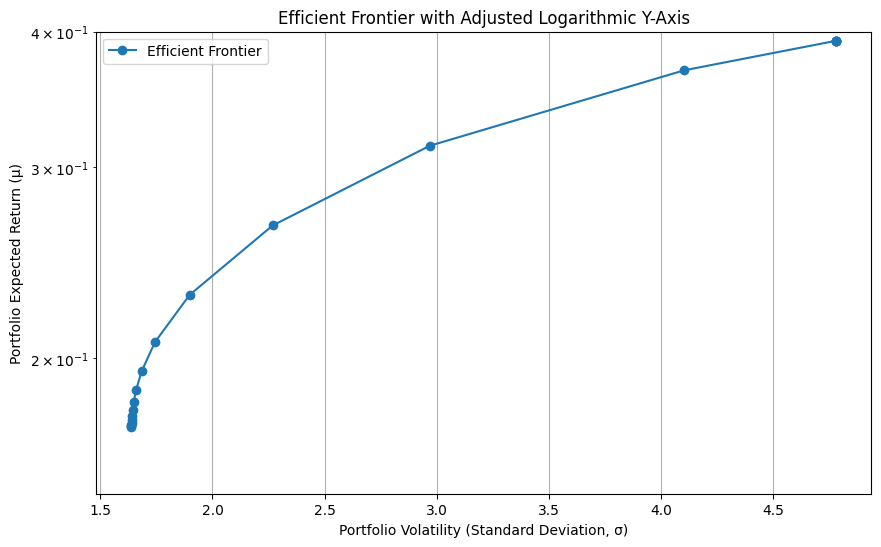

In [ ]:
import matplotlib.pyplot as plt

# Assuming portfolio_returns and portfolio_std_devs are already calculated
plt.figure(figsize=(10, 6))
plt.plot(portfolio_std_devs, portfolio_returns, 'o-', label='Efficient Frontier')
plt.xlabel('Portfolio Volatility (Standard Deviation, σ)')
plt.ylabel('Portfolio Expected Return (μ)')
plt.title('Efficient Frontier with Adjusted Logarithmic Y-Axis')
plt.legend()
plt.grid(True)

# Set the y-axis to log scale and adjust the limits
plt.yscale('log')
plt.ylim([0.15, 0.4])  # Adjust these values based on your data range

plt.show()


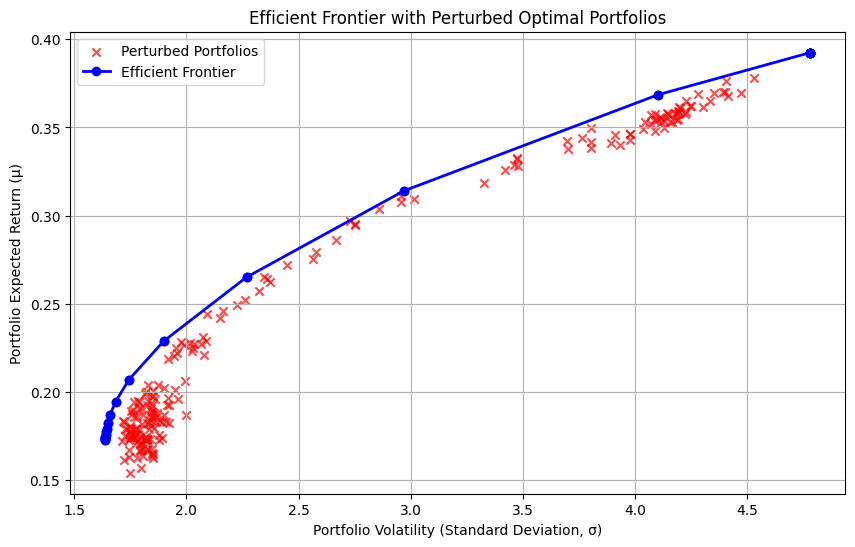

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# Initialize lists to store the perturbed portfolio returns and volatilities
perturbed_returns = []
perturbed_std_devs = []

# Set the perturbation scale
perturbation_scale = 0.02  # Adjust this value to control how much deviation to add

# Perform optimization and perturb the resulting portfolios
for risk_aversion in risk_aversion_values:
    optimized_result = minimize(
        objective_function,
        initial_weights,
        args=(expected_returns, cov_matrix_adjusted.values, risk_aversion),
        method='SLSQP',
        bounds=bounds,
        constraints=constraints
    )

    if optimized_result.success:
        optimal_weights = optimized_result.x
        portfolio_ret = portfolio_return(optimal_weights, expected_returns)
        portfolio_var = portfolio_variance(optimal_weights, cov_matrix_adjusted.values)
        portfolio_vol = np.sqrt(portfolio_var)

        # Append the optimal results to the lists
        portfolio_returns.append(portfolio_ret)
        portfolio_variances.append(portfolio_var)
        portfolio_std_devs.append(portfolio_vol)

        # Perturb the weights slightly
        for _ in range(10):  # Create 10 perturbed portfolios for each risk aversion level
            perturbed_weights = optimal_weights + np.random.normal(0, perturbation_scale, size=len(optimal_weights))
            perturbed_weights = np.clip(perturbed_weights, 0, 1)  # Clip weights between 0 and 1
            perturbed_weights /= np.sum(perturbed_weights)  # Normalize weights to sum to 1

            # Calculate the perturbed portfolio return and volatility
            perturbed_ret = portfolio_return(perturbed_weights, expected_returns)
            perturbed_var = portfolio_variance(perturbed_weights, cov_matrix_adjusted.values)
            perturbed_vol = np.sqrt(perturbed_var)

            # Append perturbed results to the lists
            perturbed_returns.append(perturbed_ret)
            perturbed_std_devs.append(perturbed_vol)

    else:
        print(f"Optimization failed at risk aversion {risk_aversion}: {optimized_result.message}")
sorted_indices = np.argsort(portfolio_std_devs)
sorted_std_devs = np.array(portfolio_std_devs)[sorted_indices]
sorted_returns = np.array(portfolio_returns)[sorted_indices]

# Plot the perturbed portfolios
plt.figure(figsize=(10, 6))
plt.scatter(perturbed_std_devs, perturbed_returns, c='red', marker='x', alpha=0.7, label='Perturbed Portfolios')

# Plot the efficient frontier (sorted points)
plt.plot(sorted_std_devs, sorted_returns, 'o-', label='Efficient Frontier', color='blue', linewidth=2)

# Set labels and title
plt.xlabel('Portfolio Volatility (Standard Deviation, σ)')
plt.ylabel('Portfolio Expected Return (μ)')
plt.title('Efficient Frontier with Perturbed Optimal Portfolios')

plt.legend()
plt.grid(True)
plt.show()

Analysis:
- For every level of risk aversion, our portfolio maximizes returns
- Every perturbed portfolio is "below" the Efficient Frontier



Shortcomings of model
- Historical winnings don't mean future winnings
- There exists no "risk free rate"/ "indiference curve" for poker
